In [1]:
import numpy as np
import torch as th

from torch.utils.data import DataLoader   # To define the data-loader

from safetensors.torch import save_model           # To save the model into the storage
from safetensors.torch import load_model           # To load the model from the storage

from IPython import display                        # To display the audio files

import librosa                                     # To manage the audio files
import soundfile as sf                             # To write the audio data into file

from src.Utility import train, plot_losses

# For reproducibility
th.manual_seed(33)
np.random.seed(33)

In [ ]:
if not "Models" in os.listdir():
    !wget "https://osf.io/drjhb/download"
    !mv download music.zip
    !unzip music.zip
    !mv Data Music

# Mel-Spectogram

In [4]:
from src.Load_Data import load_spectogram

In [3]:
audio_data, time_frame = load_spectogram()

/orfeo/cephfs/home/dssc/stumino/deep_learning/PML/src/Load_Data.py:20: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(file)
/orfeo/cephfs/home/dssc/stumino/deep_learning/lib64/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Skipping file ./Music/genres_original/jazz/.ipynb_checkpoints due to error: [Errno 21] Is a directory: './Music/genres_original/jazz/.ipynb_checkpoints'


## VAE

In [4]:
from src.VAE_Spectogram import Database
from src.VAE_Spectogram import VAE

In [5]:
BATCH_SIZE = 64

In [6]:
idxs = np.array([10, 26, 33, 42, 51, 91, 96])
database_train = Database(audio_data[idxs])
train_loader = DataLoader(database_train, BATCH_SIZE, shuffle=True)

In [7]:
N = len(database_train)

In [8]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [9]:
model = VAE(audio_data.shape[1], audio_data.shape[2], 10).to(device=device)
idx = 0
optimizer = th.optim.Adam(model.parameters(), lr=0.001)
criterion = lambda y_hat, mu, log_var, y: th.nn.functional.mse_loss(y_hat, y, reduction="sum") - 0.5 * (1 + log_var - th.pow(mu, 2) - th.exp(0.5 * log_var)).mean()

In [10]:
model = train(model, train_loader, optimizer, criterion, device, idx, 2001)

Loss: 10.072256088256836: 100%|███████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 118.78it/s]


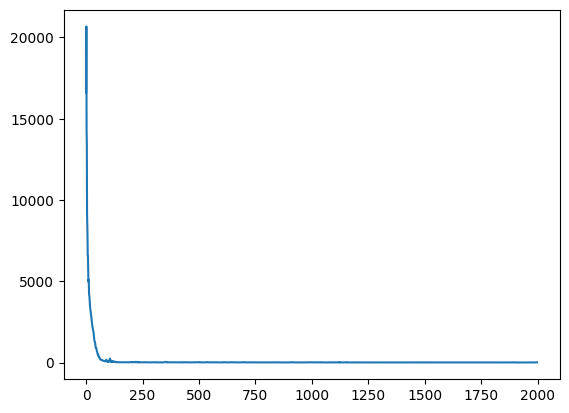

In [11]:
plot_losses()

In [12]:
o, m, s = model(database_train[1].unsqueeze(0).to(device))

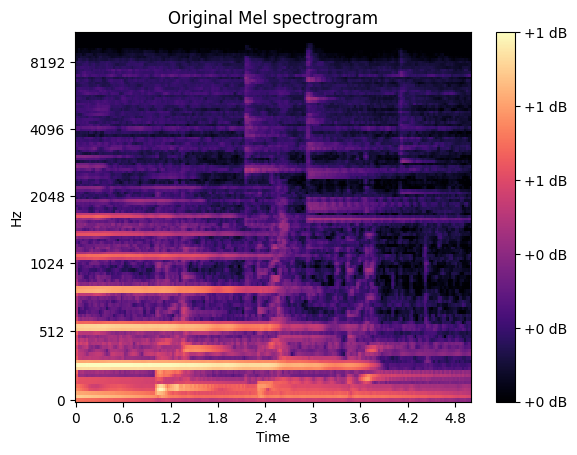

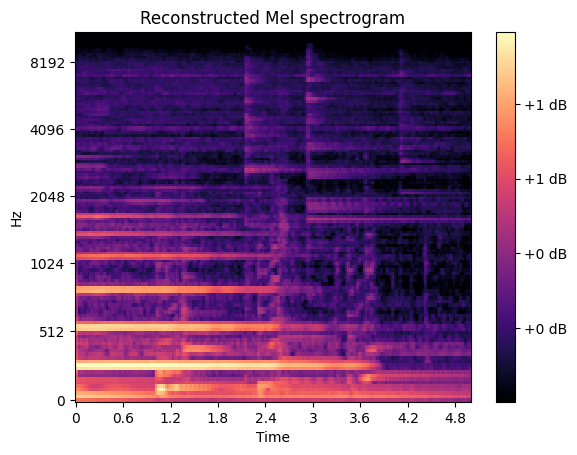

In [13]:
sr = 22050
# Plot the original and shifted Mel spectrograms
librosa.display.specshow(database_train[1].numpy(), x_axis='time', y_axis='mel', sr=sr, hop_length=512)
plt.colorbar(format='%+2.0f dB')
plt.title('Original Mel spectrogram')
plt.show()

librosa.display.specshow(o[0].detach().cpu().numpy(), x_axis='time', y_axis='mel', sr=sr, hop_length=512)
plt.colorbar(format='%+2.0f dB')
plt.title('Reconstructed Mel spectrogram')
plt.show()

In [33]:
audio = librosa.feature.inverse.mel_to_audio(o[0].detach().cpu().numpy(), sr=sr, fmax=8000, hop_length=512, n_fft=2048, fmin=30, power=1.0)

In [23]:
display.Audio(audio, rate=sr)

## RVAE

In [5]:
from src.RVAE_Spectogram import Database
from src.RVAE_Spectogram import VAE

In [6]:
audio_data, time_frame = load_spectogram()

/orfeo/cephfs/home/dssc/stumino/deep_learning/PML/src/Load_Data.py:20: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(file)
/orfeo/cephfs/home/dssc/stumino/deep_learning/lib64/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Skipping file ./Music/genres_original/jazz/.ipynb_checkpoints due to error: [Errno 21] Is a directory: './Music/genres_original/jazz/.ipynb_checkpoints'


In [7]:
BATCH_SIZE = 64

In [8]:
idxs = np.array([10, 26, 33, 42, 51, 91, 96])
database_train = Database(audio_data[idxs])
train_loader = DataLoader(database_train, BATCH_SIZE, shuffle=True)

In [9]:
N = len(database_train)

In [10]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [11]:
model = VAE(audio_data.shape[1], 50, audio_data.shape[2]).to(device=device)
idx = 0
optimizer = th.optim.Adam(model.parameters(), lr=0.00001)
criterion = lambda y_hat, mu, log_var, y: th.nn.functional.mse_loss(y_hat, y, reduction="sum") - 0.5 * (1 + log_var - th.pow(mu, 2) - th.exp(0.5 * log_var)).mean()

In [12]:
model = train(model, train_loader, optimizer, criterion, device, idx, 301)

Loss: 3452.02099609375: 100%|████████████████████████████████████████████████████████| 300/300 [03:40<00:00,  1.36it/s]


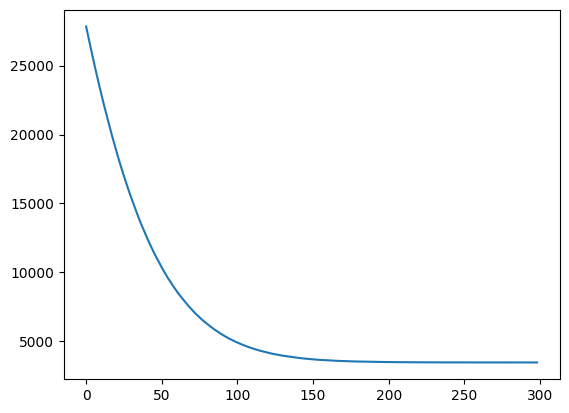

In [13]:
plot_losses()

In [14]:
o, m, s = model(database_train[1].unsqueeze(0).to(device))

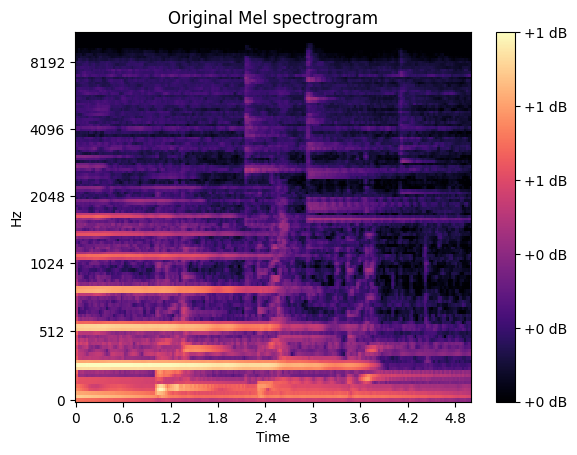

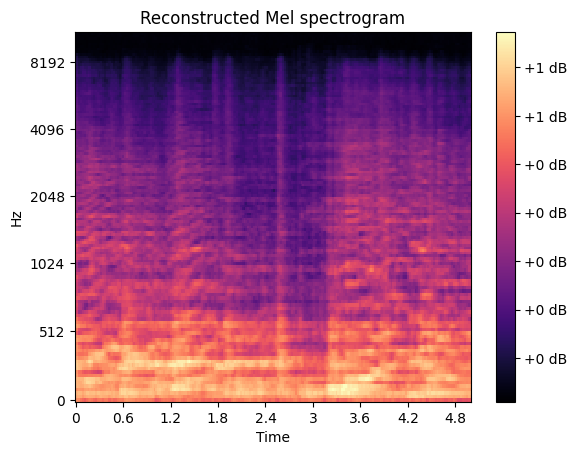

In [16]:
sr = 22050
# Plot the original and shifted Mel spectrograms
librosa.display.specshow(database_train[1].numpy(), x_axis='time', y_axis='mel', sr=sr, hop_length=512)
plt.colorbar(format='%+2.0f dB')
plt.title('Original Mel spectrogram')
plt.show()

librosa.display.specshow(o[0].detach().cpu().numpy(), x_axis='time', y_axis='mel', sr=sr, hop_length=512)
plt.colorbar(format='%+2.0f dB')
plt.title('Reconstructed Mel spectrogram')
plt.show()

In [17]:
audio = librosa.feature.inverse.mel_to_audio(o[0].detach().cpu().numpy(), sr=sr, fmax=8000, hop_length=512, n_fft=2048, fmin=30, power=1.0)

In [23]:
display.Audio(audio, rate=sr)

# Audio Data

In [2]:
from src.Load_Data import load_audio

In [6]:
audio_data = load_audio("reggae")

## CNN VAE

In [7]:
from src.CNN_Audio import Database
from src.CNN_Audio import VAE

In [5]:
BATCH_SIZE = 32

In [8]:
idxs = np.array([10, 26, 33, 42, 51, 91, 96])
database_train = Database(audio_data[idxs, :, :-1])
train_loader = DataLoader(database_train, BATCH_SIZE, shuffle=True)

In [9]:
N = len(database_train)

In [10]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [11]:
model = VAE(10, audio_data.shape[2]).to(device=device)
idx = 0
optimizer = th.optim.Adam(model.parameters(), lr=0.00001)
criterion = lambda y_hat, mu, log_var, y: th.nn.functional.mse_loss(y_hat, y, reduction="sum") - 0.5 * (1 + log_var - th.pow(mu, 2) - th.exp(0.5 * log_var)).mean()

In [12]:
model = train(model, train_loader, optimizer, criterion, device, idx, 301)

Loss: 8876.87109375: 100%|███████████████████████████████████████████████████████████| 300/300 [00:42<00:00,  7.03it/s]


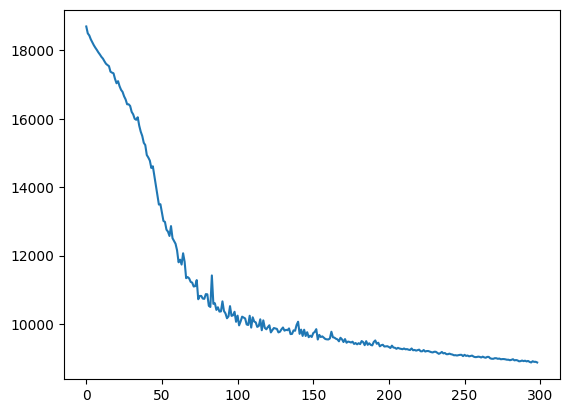

In [15]:
plot_losses()

In [16]:
model.eval()
o, m, s = model(th.from_numpy(audio_data[0, :, :-1]).unsqueeze(0).to(device))

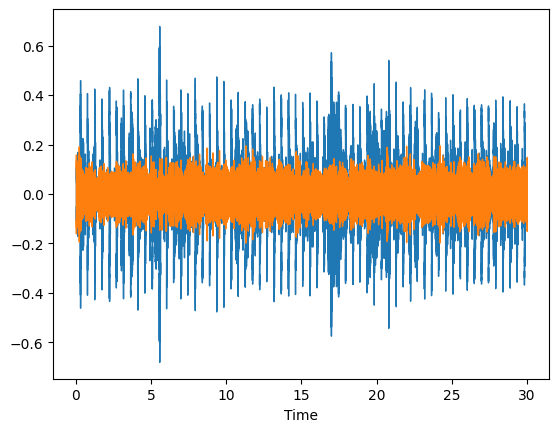

In [17]:
librosa.display.waveshow(audio_data[10, :, :-1], sr=3000)
librosa.display.waveshow(o[0].cpu().detach().numpy(), sr=3000)

In [19]:
display.Audio(o[0][0].cpu().detach().numpy(), rate=3000)

## CNN-Residual VAE

In [8]:
from src.Residual_CNN_VAE import Database
from src.Residual_CNN_VAE import VAE

In [9]:
BATCH_SIZE = 32

In [10]:
idxs = np.array([10, 26, 33, 42, 51, 91, 96])
database_train = Database(audio_data[idxs, :, :-1])
train_loader = DataLoader(database_train, BATCH_SIZE, shuffle=True)

In [11]:
N = len(database_train)

In [12]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [13]:
model = VAE(100, audio_data.shape[2]).to(device=device)
idx = 0
optimizer = th.optim.Adam(model.parameters(), lr=0.0001)
criterion = lambda y_hat, mu, log_var, y: th.nn.functional.mse_loss(y_hat, y, reduction="sum") - 0.5 * (1 + log_var - th.pow(mu, 2) - th.exp(0.5 * log_var)).mean()

In [14]:
model = train(model, train_loader, optimizer, criterion, device, idx, 301)

Loss: 10030.849609375: 100%|█████████████████████████████████████████████████████████| 300/300 [16:38<00:00,  3.33s/it]


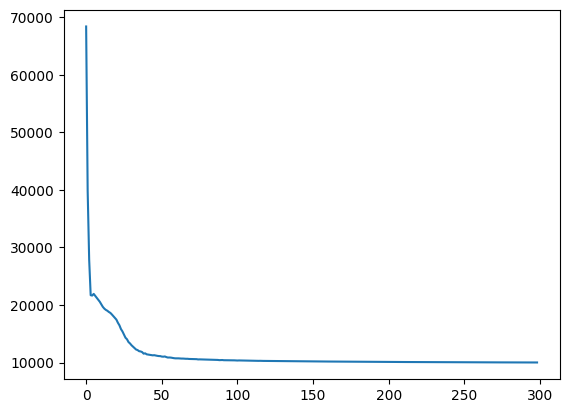

In [15]:
plot_losses()

In [16]:
o, m, s = model(th.from_numpy(audio_data[10, :, :-1]).unsqueeze(0).to(device))

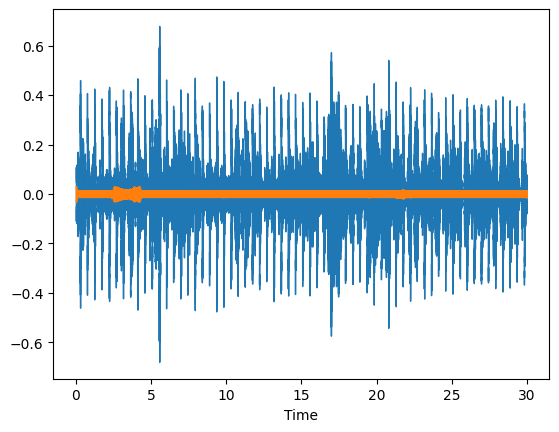

In [17]:
librosa.display.waveshow(audio_data[10, :, :-1], sr=3000)
librosa.display.waveshow(o[0].cpu().detach().numpy(), sr=3000)

In [18]:
display.Audio(audio_data[10][0], rate=3000)

In [19]:
display.Audio(o[0][0].cpu().detach().numpy(), rate=3000)

## RVAE Audio 2

In [3]:
from src.RVAE_Audio2 import Database
from src.RVAE_Audio2 import VAE

In [4]:
BATCH_SIZE = 1

In [11]:
audio_data = load_audio("reggae")
# idxs = np.array([10, 14, 20, 42, 51, 91, 96]) # jazz-1
# idxs = np.array([0, 7, 10, 14, 20, 26, 30, 32, 33, 42, 
#                  51, 56, 67, 69, 85, 86, 88, 90, 91, 93, 
#                  96, 98])                                 # jazz-2
# idxs = np.array([10, 11, 19, 23, 25, 30, 32, 36, 51, 52, 56, 65, 67, 68, 69, 71, 74, 78, 87, 89, 91, 93, 97])-10 # country
idxs = np.array([1, 2, 3, 7, 8, 9, 10, 14, 18, 21, 24, 25, 28, 40, 42, 47, 50, 52, 53, 54, 56, 57, 60, 62, 63, 71, 83, 87, 90, 91, 93, 97]) # reggae
database_train = Database(audio_data[idxs, :, :-1])
train_loader = DataLoader(database_train, BATCH_SIZE, shuffle=True)

In [6]:
# database_train = Database(audio_data[:, :, :-1])
# train_loader = DataLoader(database_train, BATCH_SIZE, shuffle=True)

In [13]:
N = len(database_train)

In [8]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [14]:
# input_dim -> features -> seconds
# num_layers -> sequence -> notes
model = VAE(3000, 2, 30).to(device=device)
idx = 0
optimizer = th.optim.Adam(model.parameters(), lr=0.0001)#, momentum=0.8, weight_decay=0.5)
criterion = lambda y_hat, mu, log_var, y: th.nn.functional.mse_loss(y_hat, y, reduction="sum") - 0.5 * (1 + log_var - th.pow(mu, 2) - th.exp(0.5 * log_var)).mean()

In [15]:
model = train(model, train_loader, optimizer, criterion, device, idx, 301)

Loss: 15.102246165275574: 100%|██████████████████████████████████████████████████████| 300/300 [15:34<00:00,  3.12s/it]


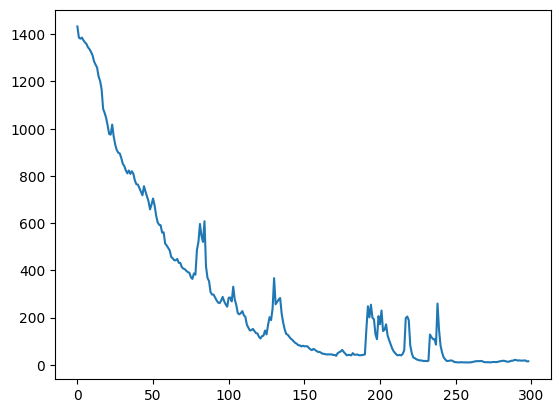

In [16]:
plot_losses()

In [17]:
import matplotlib.pyplot as plt

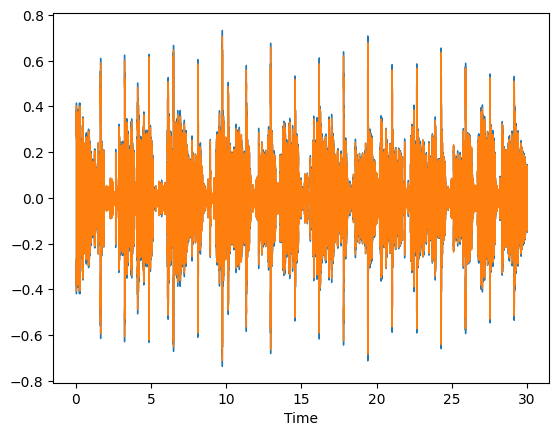

In [18]:
idx = 1
o, m, s = model(database_train[idx].unsqueeze(0).to(device))

librosa.display.waveshow(database_train[idx].reshape(1, -1).numpy(), sr=3000)
librosa.display.waveshow(o[0].cpu().detach().numpy().reshape(1, 90000), sr=3000)

display.display(display.Audio(o[0].reshape(-1).cpu().detach().numpy(), rate=3000))

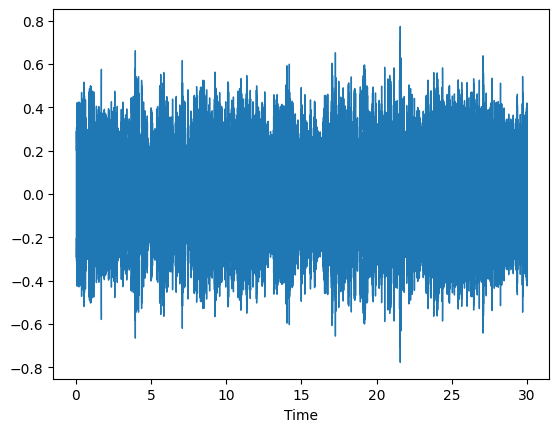

In [19]:
mu = th.randn((1, 2))*th.randint(1, 5, (1, 2))
log_var = th.rand((1, 2))*th.randint(1, 5, (1, 2))
o, m, s = model(mu=mu.to(device), log_var=log_var.to(device))

librosa.display.waveshow(o[0].cpu().detach().numpy().reshape(1, 90000), sr=3000)

display.Audio(o[0].reshape(-1).cpu().detach().numpy(), rate=3000)

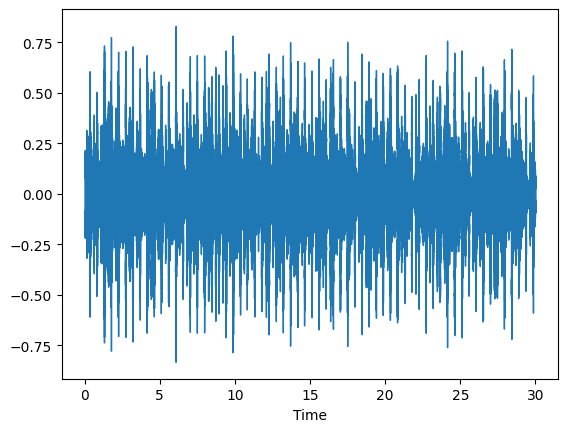

In [20]:
mu = th.zeros((1, 2))
log_var = th.zeros((1, 2)) - th.inf

# mu[0, 1] = 1
log_var[0, 1] = 4

o, m, s = model(mu=mu.to(device), log_var=log_var.to(device))

librosa.display.waveshow(o[0].cpu().detach().numpy().reshape(1, 90000), sr=3000)

display.Audio(o[0].reshape(-1).cpu().detach().numpy(), rate=3000)

### Mean-Variance distributions

In [21]:
means = []
log_vars = []
for song in database_train:
    o, m, s = model(song.unsqueeze(0).to(device))
    means.append(m[0].cpu().detach().numpy())
    log_vars.append(s[0].cpu().detach().numpy())

In [22]:
import matplotlib.patches as patches

In [23]:
means = np.array(means)
log_vars = np.array(log_vars)

/tmp/ipykernel_2619026/3457005711.py:10: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(patches.Ellipse((x, y), w, h, color=colors[i], edgecolor="black", alpha=.2))


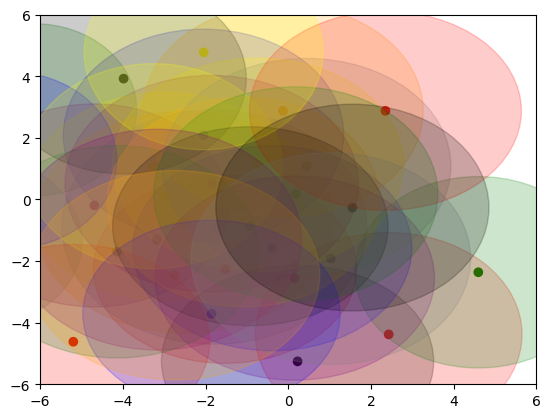

In [27]:
plt.figure()
ax = plt.gca()
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)

colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', "gray", "black"]*4

ax.scatter(means[:, 0], means[:, 1], color=colors)
for i, (x, y, w, h) in enumerate(zip(means[:, 0], means[:, 1], log_vars[:, 0], log_vars[:, 1])):
    ax.add_patch(patches.Ellipse((x, y), w, h, color=colors[i], edgecolor="black", alpha=.2))


### Mean-Variance interpretation

In [28]:
import matplotlib.pyplot as plt

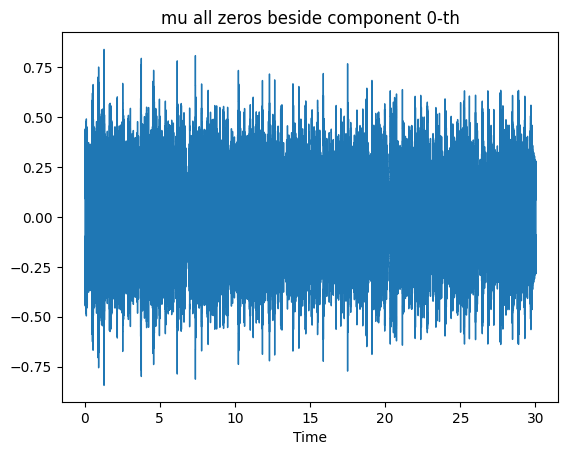

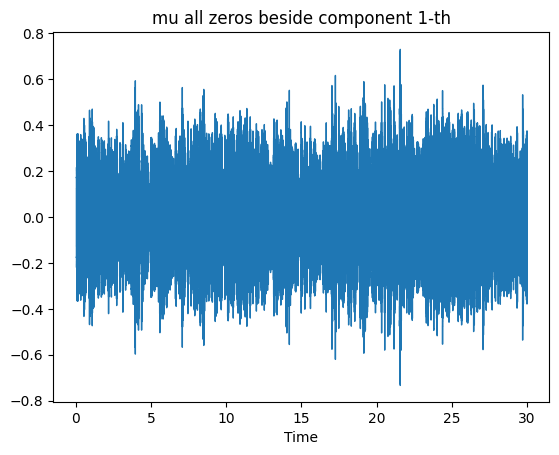

In [29]:
for i in range(2):
    mu = th.zeros((1, 2))
    log_var = -th.inf + th.zeros((1, 2))
    
    mu[0, i] = 5
    
    o, m, s = model(mu=mu.to(device), log_var=log_var.to(device))
    
    librosa.display.waveshow(o[0].cpu().detach().numpy().reshape(1, 90000), sr=3000)
    
    display.display(display.Audio(o[0].reshape(-1).cpu().detach().numpy(), rate=3000))
    plt.title(f"mu all zeros beside component {i}-th")
    plt.show()

## RVAE Audio - Mix

In [63]:
from src.RVAE_Audio2 import Database
from src.RVAE_Audio2 import VAE

In [64]:
BATCH_SIZE = 32

In [65]:
audio_data_jazz = load_audio("jazz")
audio_data_country = load_audio("country")
audio_data_reggae = load_audio("reggae")

In [66]:
# idxs = np.array([10, 26, 33, 42, 51, 91, 96])  # jazz-1
idxs_jazz = np.array([0, 7, 10, 14, 20, 90, 91, 93, 96, 98])         # jazz-2
idxs_country = np.array([10, 11, 19, 23, 25, 87, 89, 91, 93, 97])-10 # country
idxs_reggae = np.array([1, 2, 3, 7, 8, 87, 90, 91, 93, 97])          # reggae

audio_data = np.concatenate((audio_data_jazz[idxs_jazz, :, :-1], audio_data_country[idxs_country, :, :-1], audio_data_reggae[idxs_reggae, :, :-1]), axis=0)

database_train = Database(audio_data)
train_loader = DataLoader(database_train, 1, shuffle=True)

In [62]:
# database_train = Database(audio_data[:, :, :-1])
# train_loader = DataLoader(database_train, BATCH_SIZE, shuffle=True)

In [67]:
N = len(database_train)

In [68]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [69]:
# input_dim -> features -> seconds
# num_layers -> sequence -> notes
model = VAE(3000, 3, 30).to(device=device)
idx = 0
optimizer = th.optim.Adam(model.parameters(), lr=0.0001)#, momentum=0.8, weight_decay=0.5)
criterion = lambda y_hat, mu, log_var, y: th.nn.functional.mse_loss(y_hat, y, reduction="sum") - 0.5 * (1 + log_var - th.pow(mu, 2) - th.exp(0.5 * log_var)).mean()

In [70]:
model = train(model, train_loader, optimizer, criterion, device, idx, 301)

Loss: 14.255793857574464: 100%|██████████████████████████████████████████████████████| 300/300 [14:41<00:00,  2.94s/it]


In [96]:
plot_losses()

In [72]:
o, m, s = model(database_train[0].unsqueeze(0).to(device))

librosa.display.waveshow(database_train[0].reshape(1, -1).numpy(), sr=3000)
librosa.display.waveshow(o[0].cpu().detach().numpy().reshape(1, 90000), sr=3000)

display.Audio(o[0].reshape(-1).cpu().detach().numpy(), rate=3000)

In [73]:
mu = th.randn((1, 3))*th.randint(1, 5, (1, 3))
log_var = th.rand((1, 3))*th.randint(1, 5, (1, 3))
o, m, s = model(mu=mu.to(device), log_var=log_var.to(device))

librosa.display.waveshow(o[0].cpu().detach().numpy().reshape(1, 90000), sr=3000)

display.Audio(o[0].reshape(-1).cpu().detach().numpy(), rate=3000)

### Mean-Variance distributions

In [74]:
means = []
log_vars = []
for song in database_train:
    o, m, s = model(song.unsqueeze(0).to(device))
    means.append(m[0].cpu().detach().numpy())
    log_vars.append(s[0].cpu().detach().numpy())

In [75]:
import matplotlib.pyplot as plt

%matplotlib widget

In [76]:
means = np.array(means)
log_vars = np.array(log_vars)

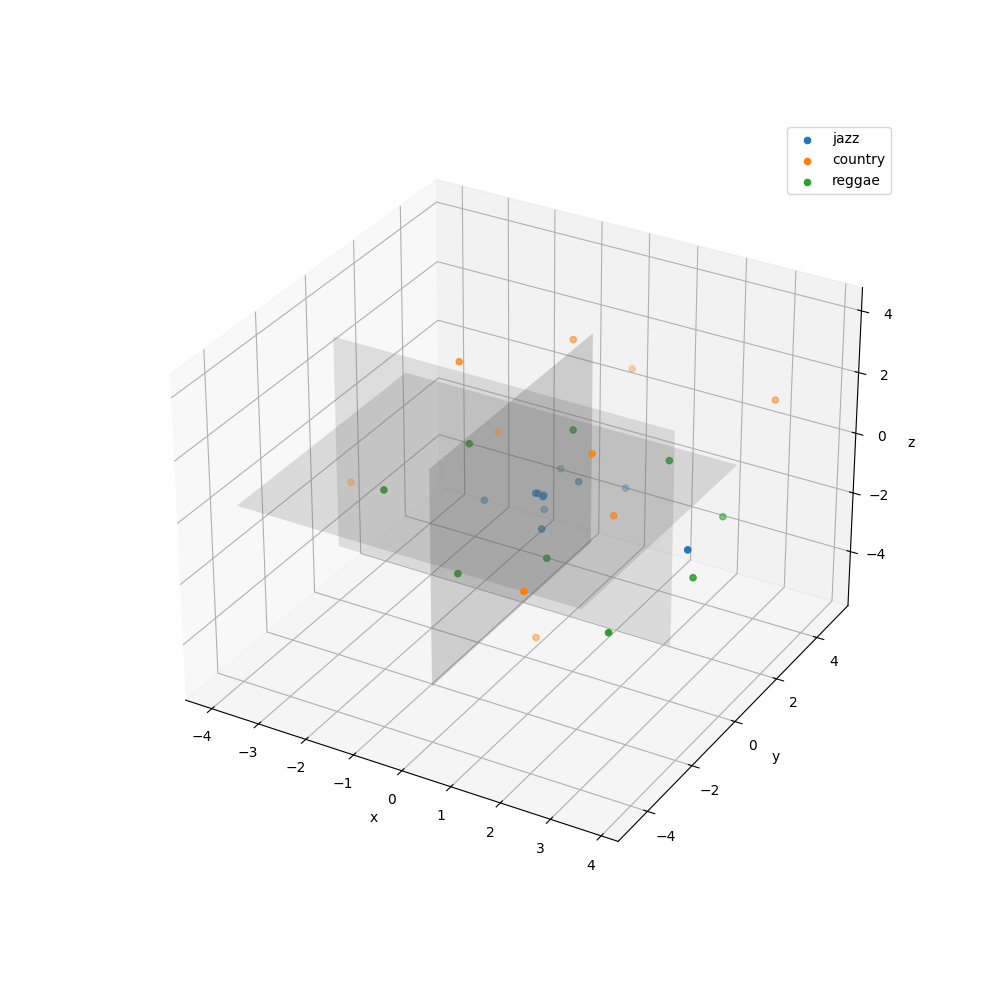

In [113]:
xx, yy = np.meshgrid(range(-4, 4), range(-4, 4))
zz = np.zeros_like(xx)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(means[:10, 0], means[:10, 1], means[:10, 2], label="jazz")
ax.scatter(means[10:20, 0], means[10:20, 1], means[10:20, 2], label="country")
ax.scatter(means[20:, 0], means[20:, 1], means[20:, 2], label="reggae")

ax.plot_surface(0, xx, yy, alpha=0.2, color="gray")
ax.plot_surface(xx, 0, yy, alpha=0.2, color="gray")
ax.plot_surface(xx, yy, zz, alpha=0.2, color="gray")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend()
plt.show()

In [100]:
# jazz (>0, >0, <0)     1-st  > jazz < country
# country (>0, >0, >0)  2-nd  > country < country
# reggae (>0, 0, <0)    3-rd  > reggae < country

In [78]:
# reggae (<0, <0, >0)  1-st   <0 -> jazz; >0 -> reggae
# jazz (<0, >0, 0)     2-nd   != 0 -> country
# country (>0, 0, 0)   3-rd   <0 -> country; >0 -> reggae (less noise)

### Mean-Variance interpretation

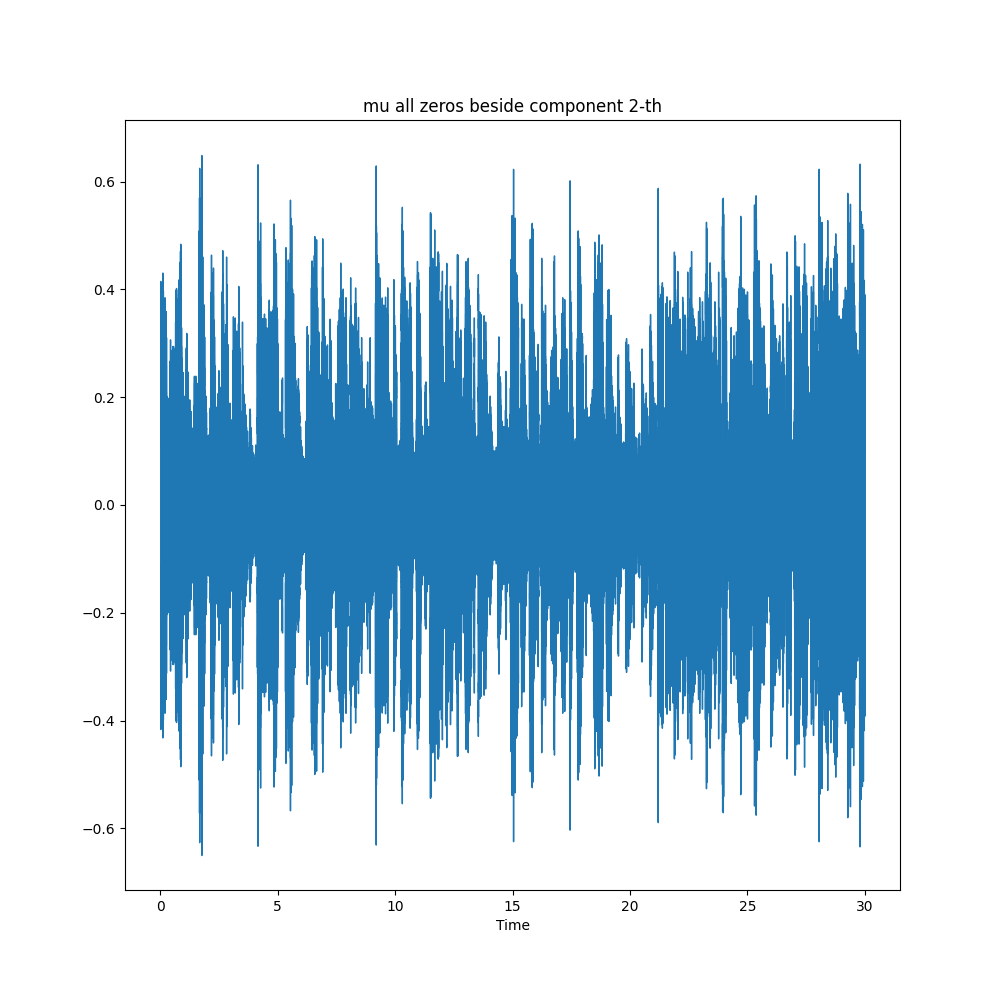

In [123]:
mu = th.zeros((1, 3))
log_var = -th.inf + th.zeros((1, 3))

mu[0, 0] = 0        
mu[0, 1] = 0       
mu[0, 2] = -5          

o, m, s = model(mu=mu.to(device), log_var=log_var.to(device))

plt.clf()
librosa.display.waveshow(o[0].cpu().detach().numpy().reshape(1, 90000), sr=3000)

display.display(display.Audio(o[0].reshape(-1).cpu().detach().numpy(), rate=3000))
plt.title(f"mu all zeros beside component {(mu != 0).int().argmax()}-th")
plt.show()

In [124]:
# th.save(model.state_dict(), "Models/model.tensor")

In [15]:
# state_dict = th.load("model.tensor")
# model.load_state_dict(state_dict)

<All keys matched successfully>